<a href="https://colab.research.google.com/github/rua-maomao/ECG-EMG-noise-reduce/blob/main/ECG_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [ ]:
# Load the ECG data from an Excel file
data = pd.read_excel('/content/data processing SCC PBS.xlsx')
ecg_signal = data['Voltage (mV)']
sampling_rate = 1 / (data['Time (s)'][1] - data['Time (s)'][0])  # Calculate sampling rate from time differences

# Invert the signal immediately after loading
ecg_signal = -ecg_signal

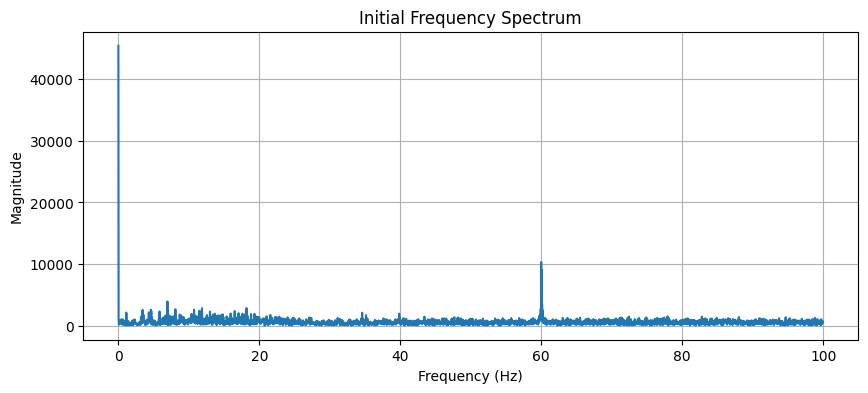

(array([ 0.        ,  0.03223207,  0.06446414, ..., -0.09669621,
        -0.06446414, -0.03223207]),
 array([45416.59895186,  1016.05764438,   161.26894966, ...,
          248.16438763,   161.26894966,  1016.05764438]))

In [ ]:
# Function to perform FFT and plot the frequency spectrum
def fft_analysis(signal, sampling_rate, title="Frequency Spectrum"):
    n = len(signal)
    freq = np.fft.fftfreq(n, d=1/sampling_rate)
    fft_values = np.fft.fft(signal)
    magnitude = np.abs(fft_values)
    plt.figure(figsize=(10, 4))
    plt.plot(freq[:n // 2], magnitude[:n // 2])  # Plot only positive frequencies
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()
    return freq, magnitude

# Initial FFT analysis
fft_analysis(ecg_signal, sampling_rate, "Initial Frequency Spectrum")

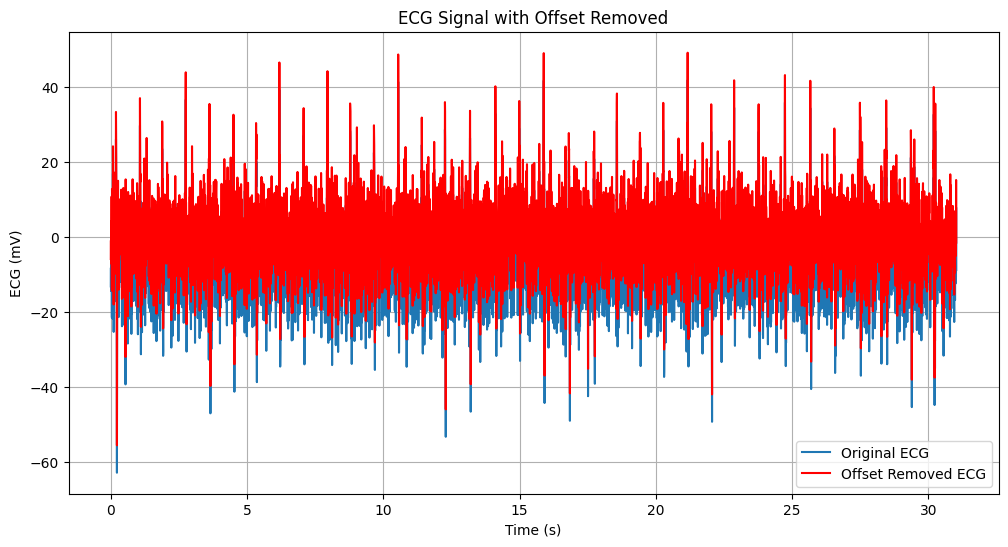

In [ ]:
# Function to remove DC offset and plot
def remove_offset(signal):
    offset_removed_signal = signal - np.mean(signal)
    plt.figure(figsize=(12, 6))
    plt.plot(data['Time (s)'], signal, label='Original ECG')
    plt.plot(data['Time (s)'], offset_removed_signal, label='Offset Removed ECG', color='red')
    plt.title("ECG Signal with Offset Removed")
    plt.xlabel("Time (s)")
    plt.ylabel("ECG (mV)")
    plt.legend()
    plt.grid(True)
    plt.show()
    return offset_removed_signal

# Remove DC offset
ecg_offset_removed = remove_offset(ecg_signal)

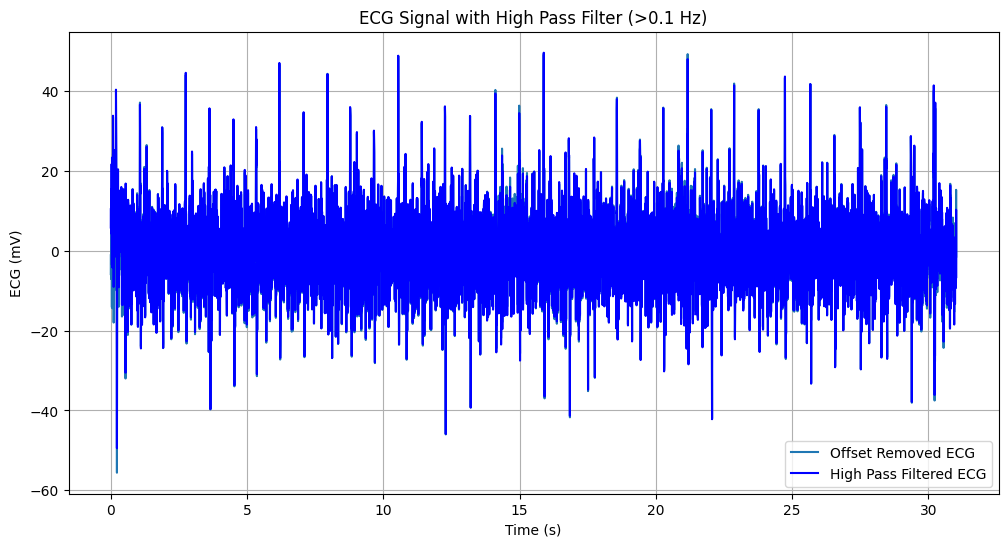

In [ ]:
# Function to apply a high-pass filter to remove frequencies below 0.1 Hz
def high_pass_filter(signal, cutoff_freq, sampling_rate):
    b, a = butter(2, cutoff_freq / (sampling_rate / 2), btype='high')
    high_passed_signal = filtfilt(b, a, signal)
    plt.figure(figsize=(12, 6))
    plt.plot(data['Time (s)'], signal, label='Offset Removed ECG')
    plt.plot(data['Time (s)'], high_passed_signal, label='High Pass Filtered ECG', color='blue')
    plt.title("ECG Signal with High Pass Filter (>0.1 Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("ECG (mV)")
    plt.legend()
    plt.grid(True)
    plt.show()
    return high_passed_signal

# Apply high pass filter
ecg_high_passed = high_pass_filter(ecg_offset_removed, 0.5, sampling_rate)

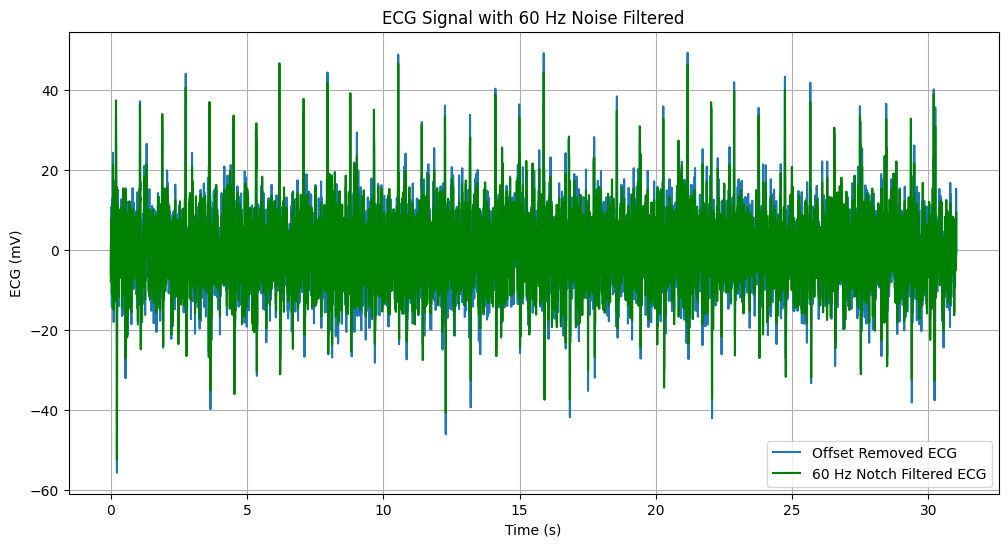

In [ ]:
# Design and apply a notch filter to remove 60 Hz noise
def notch_filter(signal, notch_freq, bandwidth, sampling_rate):
    Q = notch_freq / bandwidth
    b, a = butter(2, [notch_freq - 0.5, notch_freq + 0.5], btype='bandstop', fs=sampling_rate)
    filtered_signal = filtfilt(b, a, signal)
    plt.figure(figsize=(12, 6))
    plt.plot(data['Time (s)'], signal, label='Offset Removed ECG')
    plt.plot(data['Time (s)'], filtered_signal, label='60 Hz Notch Filtered ECG', color='green')
    plt.title("ECG Signal with 60 Hz Noise Filtered")
    plt.xlabel("Time (s)")
    plt.ylabel("ECG (mV)")
    # plt.xlim(10, 15)
    plt.legend()
    plt.grid(True)
    plt.show()
    return filtered_signal

# Apply notch filter
ecg_notch_filtered = notch_filter(ecg_offset_removed, 60, 1, sampling_rate)


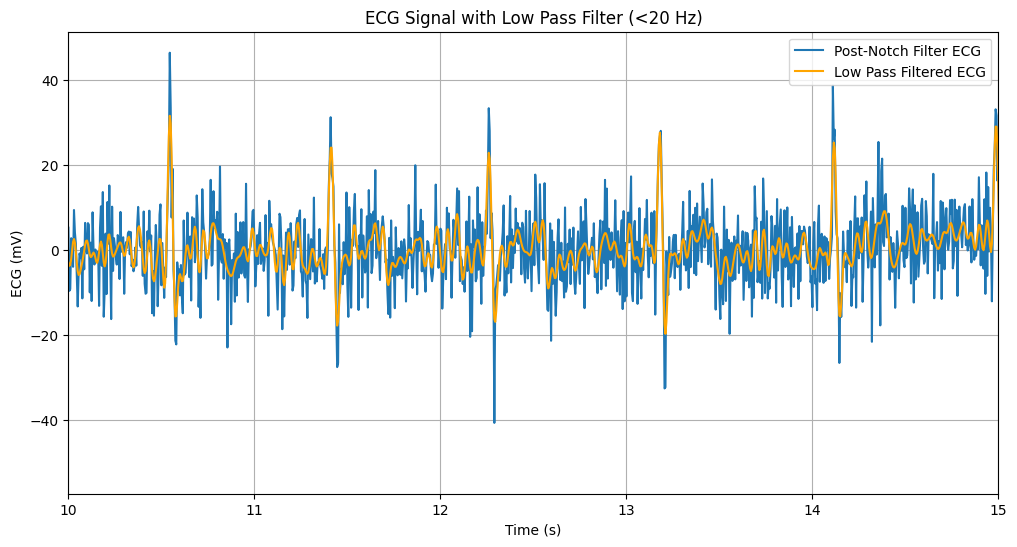

In [ ]:
# Apply a low-pass filter to allow only frequencies lower than 25 Hz
def low_pass_filter(signal, time, cutoff_freq, sampling_rate):
    b, a = butter(5, cutoff_freq / (sampling_rate / 2), btype='low')
    low_passed_signal = filtfilt(b, a, signal)
    plt.figure(figsize=(12, 6))
    plt.plot(time, signal, label='Post-Notch Filter ECG')
    plt.plot(time, low_passed_signal, label='Low Pass Filtered ECG', color='orange')
    plt.title("ECG Signal with Low Pass Filter (<20 Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("ECG (mV)")
    plt.xlim(10, 15)
    plt.legend()
    plt.grid(True)
    plt.show()
    return low_passed_signal

# Apply low pass filter
ecg_low_passed = low_pass_filter(ecg_notch_filtered, data['Time (s)'], 25, sampling_rate)

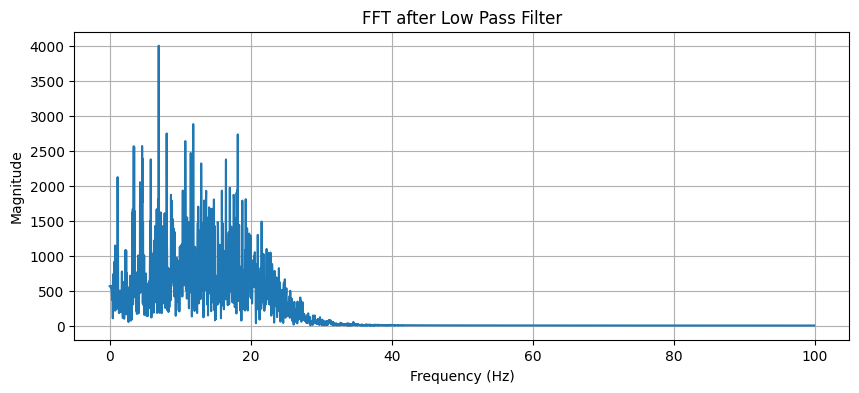

In [ ]:
# FFT analysis after low-pass filtering
freq, fft_values = fft_analysis(ecg_low_passed, sampling_rate, "FFT after Low Pass Filter")

In [ ]:
# Save the processed signal to an Excel file
df_processed = pd.DataFrame({
    'Time (s)': data['Time (s)'],
    'Processed ECG (mV)': ecg_low_passed
})
df_processed.to_excel('/content/filtered SCC PBS.xlsx', index=False)